# Problem Set 1
### Cameron Smith

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Ellipse
import scipy.optimize as op
import emcee
from corner import corner

Load in Data:

In [2]:
_, x, y, y_err, x_err, rho_xy = data = np.array([
    [1,  201, 592, 61,  9, -0.84],
    [2,  244, 401, 25,  4, +0.31],
    [3,   47, 583, 38, 11, +0.64],
    [4,  287, 402, 15,  7, -0.27],
    [5,  203, 495, 21,  5, -0.33],
    [6,   58, 173, 15,  9, +0.67],
    [7,  210, 479, 27,  4, -0.02],
    [8,  202, 504, 14,  4, -0.05],
    [9,  198, 510, 30, 11, -0.84],
    [10, 158, 416, 16,  7, -0.69],
    [11, 165, 393, 14,  5, +0.30],
    [12, 201, 442, 25,  5, -0.46],
    [13, 157, 317, 52,  5, -0.03],
    [14, 131, 311, 16,  6, +0.50],
    [15, 166, 400, 34,  6, +0.73],
    [16, 160, 337, 31,  5, -0.52],
    [17, 186, 423, 42,  9, +0.90],
    [18, 125, 334, 26,  8, +0.40],
    [19, 218, 533, 16,  6, -0.78],
    [20, 146, 344, 22,  5, -0.56],
]).T

## Question 1

We have a model given by:
$$ y_i \sim \mathcal{N}(mx_i+b,\sigma_{y_i}) \quad .$$

i.e. a normal distribution centered at $y_i = m x_i$ with a standard deviation: $\sigma_{y_i}$, for each $i \in \{1, ..., n\} $.

To convert this to matrix form, we first, we define the following matrices

$$
\mathbf{Y} = \left[\begin{array}{c}
            y_{1} \\
            y_{2} \\
            \cdots \\
            y_N \end{array}\right]\\
\mathbf{A} = \left[\begin{array}{cc}
        1 & x_1 \\
        1 & x_2 \\
        1 & \cdots \\
        1 & x_N
        \end{array}\right]\\        
\mathbf{C} = \left[\begin{array}{cccc}
        \sigma_{y1}^2 & 0 & \cdots & 0 \\
        0 & \sigma_{y2}^2 & \cdots & 0 \\
        0 & 0 & \ddots & 0 \\
        0 & 0 & \cdots & \sigma_{yN}^2 
        \end{array}\right] \\        
$$

$$
\mathbf{X} = \left[\begin{array}{c} b \\ m \end{array}\right]
$$

Where, $\mathbf{A}$ is the design matrix and $\mathbf{C}$ is the covariance matrix. Note that based on our model, each point $y_i$ depends only on $\sigma_{y_i}$, i.e. there are no covariences, and therfore no off-diagonal components on the covarience matrix. Our line equation ($y_i = m x_i$) is therefore given by 

$$
        \mathbf{Y} = \mathbf{A}\mathbf{X} \quad .
$$

This is overconstrained however, and so we must weight each datapoint with the covarience matrix:

$$
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\begin{array}{rcl}
\mathbf{Y} &=& \mathbf{AX} \\
\mathbf{C}^{-1}\mathbf{Y} &=& \mathbf{C}^{-1}\mathbf{AX} \\
\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y} &=& \mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{AX} \\
\left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y}\right] &=& \left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{A}\right]\mathbf{X}
\end{array}
$$

And so the best fit values for $\mathbf{X}$ (i.e. the parameters which maximise the likelihood of the data) are given by:

$$
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\mathbf{X} = \left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{A}\right]^{-1}\left[\mathbf{A}\transpose\mathbf{C}^{-1}\mathbf{Y}\right] \quad .
$$


This could also be done by maximising the likelihood of the data explicitly. To do this, we introduce the expected frequency distribution, which is given by:

$$p(y_i|x_i,\sigma_{yi},m,b) = \frac{1}{\sqrt{2\pi\sigma_{yi}^2}}\exp\left(-\frac{\left[y_i-mx_i - b\right]^2}{2\sigma_{yi}^2}\right)$$

The total likelihood is then the probability of all the data given our model, and so assuming all data points are independant, we get:
$$
\mathcal{L} = \prod_{i=1}^{N}p(y_i|x_i,\sigma_{yi},m,b) \quad .
$$

By finding the parameters that maximise the likelihood, we find the most likely parameters given our model. Since logarithims are monatonic, we can equivelently maximise the log likelihood, which is given by:

$$
\log{\mathcal{L}} = -\sum_{i=1}^{N}\frac{\left[y_i-mx_i-b\right]^2}{2\sigma_{yi}^2} - \sum_{i=1}^{N}\log{\sigma_{yi}} - \frac{N}{2}\log{2\pi}
$$

However since the last two sums are constant ($\sigma_{yi}$ is constant), this is equivalent to maximising the first sum, or minimasing $\chi^2$, where

$$ 
            \newcommand{\transpose}{^{\scriptscriptstyle \top}}
            \chi^2 = \sum_{i=1}^{N} \frac{\left[y_{i} - f(x_i)\right]^2}{\sigma_{yi}^2} \quad \equiv \quad \left[\mathbf{Y}-\mathbf{AX}\right]\transpose\mathbf{C}^{-1}\left[\mathbf{Y} - \mathbf{AX}\right] \quad .
$$

## Question 2

We have:

$$ 
            \newcommand{\transpose}{^{\scriptscriptstyle \top}}
            \chi^2 = \quad \left[\mathbf{Y}-\mathbf{AX}\right]\transpose\mathbf{C}^{-1}\left[\mathbf{Y} - \mathbf{AX}\right] \quad .
$$

However, $\quad \left[\mathbf{Y}-\mathbf{AX}\right]\transpose\mathbf{C}^{-1}$ is a row vector matrix multiplied by the column vector $\left[\mathbf{Y} - \mathbf{AX}\right]$ . As such, this is equivalent to the dot product of two collumn vectors as follows:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\chi^2 = \quad \left[\left[\mathbf{Y}-\mathbf{AX}\right]\transpose\mathbf{C}^{-1}\right]\transpose \cdot \left[\mathbf{Y} - \mathbf{AX}\right]
$$

Simplifying the transpose gives:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\chi^2 = \quad \left[\mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right]\right] \cdot \left[\mathbf{Y} - \mathbf{AX}\right]
$$

(Note that $C^{-1 \, T} = C^{T\, -1} = C^{-1}$ since $C$ is symmetric)

Taking the derivative with respect to $\mathbf{X}$, we get:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\frac{d \chi^2}{d \mathbf{X}} = \quad \left[\mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right]\right]\transpose \frac{d \left[\mathbf{Y} - \mathbf{AX}\right]}{d \mathbf{X}} + \left[\mathbf{Y} - \mathbf{AX}\right]\transpose \frac{d \left[\mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right]\right]}{d \mathbf{X}} 
$$

where we have used the identity:
$$
\frac{d (\mathbf{u} \cdot \mathbf{v})}{d \mathbf{x}} = \mathbf{u}^\top\frac{d \mathbf{v}}{d \mathbf{x}} + \mathbf{v}^\top\frac{d \mathbf{u}}{d \mathbf{x}}
$$

This gives:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\frac{d \chi^2}{d \mathbf{X}} = \quad \left[\mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right]\right]\transpose\left[-\mathbf{A}\right] + \left[\mathbf{Y} - \mathbf{AX}\right]\transpose  \left[-\mathbf{C}^{-1}\mathbf{A}\right]
$$

Carrying through the transpose in the first term, we get:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\frac{d \chi^2}{d \mathbf{X}} = \quad -2\left[\mathbf{Y}-\mathbf{AX}\right]\transpose \mathbf{C}^{-1}\mathbf{A}
$$

However, as explained in Question 1, by finding the parameters that minimise $\mathbf{\chi}^2$ we are finding the best fit solution to $\mathbf{Y} = \mathbf{A}\mathbf{X}$.
To find the minimum of $\mathbf{\chi}^2$, we must set the derivative to zero.

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\begin{array}{rcl}
0 &=& \quad -2\left[\mathbf{Y}-\mathbf{AX}\right]\transpose \mathbf{C}^{-1}\mathbf{A} \\
 &=& \quad \left[\mathbf{Y}-\mathbf{AX}\right]\transpose \mathbf{C}^{-1}\mathbf{A}
\end{array}
$$

However since the transpose of a scalar is itself, this is equivalent to:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\begin{array}{rcl}
0 &=&  \left[\left[\mathbf{Y}-\mathbf{AX}\right]\transpose \mathbf{C}^{-1}\mathbf{A}\right]\transpose \\
 &=&   \left[\mathbf{C}^{-1}\mathbf{A}\right]\transpose\left[\mathbf{Y}-\mathbf{AX}\right] \\
 &=&   \mathbf{A}\transpose \mathbf{C}^{-1}\left[\mathbf{Y}-\mathbf{AX}\right] \\
 &=&  \mathbf{A}\transpose \mathbf{C}^{-1}\mathbf{Y} - \mathbf{A}\transpose \mathbf{C}^{-1}\mathbf{AX}
\end{array}
$$

And so:

$$ 
\newcommand{\transpose}{^{\scriptscriptstyle \top}}
\begin{array}{rcl}
 \mathbf{A}\transpose \mathbf{C}^{-1}\mathbf{AX}&=&  \mathbf{A}\transpose \mathbf{C}^{-1}\mathbf{Y}
\end{array}
$$

Giving us

$$
\newcommand{\vec}{\mathbf}
\vec{X} = \left(\vec{A}\transpose\vec{C}^{-1}\vec{A}\right)^{-1}\left(\vec{A}\transpose\vec{C}^{-1}\vec{Y}\right) \quad ,$$

as required.

## Question 3

We want to find the matrix that projects the intrinsic scatter $\lambda$ perpendicular to the line $y = mx + b$.

Such a projection matrix must project any arbitrary vector, say $\mathbf{u}\transpose = \left[u_x \,\,\,u_y\right]$, onto a vector perpendicular to the line. I.e. we want to find a matrix $\mathbf{M}$ such that

$$ \mathbf{u_v} = \mathbf{M} \mathbf{u}$$

Where $\mathbf{u_v}$ is the projection of $\mathbf{u}$ onto $\mathbf{v}$, and $\mathbf{v}\transpose = \left[-m \,\,\,1\right]$ is a vector perpendicular to the line. Note that this matrix does not yet project the intrinsic scatter, just the vector itself. (We can see that $\mathbf{v}$ is perpendicular to the line by noting it's 'gradient', $v_y/v_x = -1/m$, is that of a line perpendicular to our line.)

However, we know that:

$$ \mathbf{u_v} = (\mathbf{u} \cdot \hat{\mathbf{v}})\hat{\mathbf{v}}$$

But
$$\hat{\mathbf{v}} = \frac{1}{\sqrt{m^2 + 1}}\begin{bmatrix}
         -m \\
         1
  \end{bmatrix}$$

And so we find:

$$\begin{array}{} \mathbf{u_v} &=& \frac{1}{m^2 + 1}(\mathbf{u} \cdot \mathbf{v})
\begin{bmatrix}
         -m \\
         1
\end{bmatrix} \\
 &=&\frac{1}{m^2 + 1}(-mu_x + u_y)
\begin{bmatrix}
         -m \\
         1
\end{bmatrix}\end{array}$$

Let $u_{v,x}$, $u_{v,y}$ be the $x$ and $y$ components of $\mathbf{u_v}$ respectively. Then

$$
\begin{array}{}
u_{v,x} &=& \frac{1}{m^2 + 1}(mu_x - u_y)m \\
&=& \frac{1}{m^2 + 1}
[ \ m^2 \,\,\, -m \, ]
\begin{bmatrix}
         u_x \\
         u_y
\end{bmatrix}
\end{array}$$

And

$$
\begin{array}{}
u_{v,y} &=& \frac{1}{m^2 + 1}(-mu_x + u_y) \\
&=& \frac{1}{m^2 + 1}
[ \, -m \,\,\, 1 \, ]
\begin{bmatrix}
         u_x \\
         u_y
\end{bmatrix}
\end{array}$$

However this is identical to the matrix multiplication:

$$\mathbf{u_v} = \frac{1}{m^2 + 1}\left[\begin{array}{cc} m^2 & -m \\ -m & 1 \end{array}\right] \bf{u}$$

And so we've found our projection matrix,

$$\vec{M} = \frac{1}{1 + m^2}\left[\begin{array}{cc} m^2 & -m \\ -m & 1 \end{array}\right] \quad .$$

Therefore to project the scatter perpendicular to out line, we use the matrix:

$$\begin{array}{}
\vec{\Lambda} &=& \lambda^2 \mathbf{M} \\
&=& \frac{\lambda^2}{1 + m^2}\left[\begin{array}{cc} m^2 & -m \\ -m & 1 \end{array}\right] \quad .\end{array}$$

Note that $\lambda$ acts analogous to the standard deviation, and $\Lambda$ acts analagous to the covariance, hence the $\lambda^2$ instead of $\lambda$.

## Question 4

We have the following datapoints

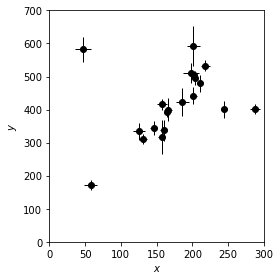

In [3]:
fig, ax = plt.subplots(figsize=(4, 4))
    
ax.scatter(x, y, c="k", s=10)
ax.errorbar(x, y,
            xerr=x_err, yerr=y_err, 
            fmt="o", lw=1, c="k")
ax.set_xlim(0, 300)
ax.set_ylim(0, 700)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
fig.tight_layout()

We assume that:
1. the $y$ values are generated by a straight line
2. there is some intrinsic scatter to the line
3. there are uncertainties in the $x$ and $y$ direction, and
4. there is no correlation between the $x$ and $y$ uncertainties.


From 1. we can see that we must have model parameters $m$ and $b$ to specify the gradient and intercept of the line respectively. We assume that $b$ is uniformly distributed, and $m$ is uniformly distributed in $\sin\theta$, where $\theta$ is the angle the line makes with the $x$-axis. Thefore, we use the joint prior:

$$
        p(m,b) \propto (1 + m^2)^{-3/2} \,,
$$

 We further assume that the measured values are drawn from a two-dimensional multivariate normal distribution, centred around the true values, i.e.

$$
            \left(\begin{array}{c}
                x_i \\
                y_i
                \end{array}
                \right) \sim \mathcal{N}\left(\left[\begin{array}{c}
                \hat{x}_i \\
                m\hat{x}_i + b
                \end{array}\right],\mathbf{C}_{T,i}\right)
    $$

Where $\mathbf{C}_T$ is our *total* variance.

From 2. and 3., we find:

$$\mathbf{C}_{T,i} = \mathbf{C}_i + \mathbf{\Lambda} \, ,$$

where $\mathbf{C}$ is our usual covariance matrix, and $\mathbf{\Lambda}$ is the scattering covariance.

From 3. and 4., we find:

$$
        \mathbf{C}_i \,=\, \left[\begin{array}{cc}
        \sigma_{xi}^2 & 0 \\
        0 & \sigma_{yi}^2
        \end{array}
        \right] \quad ,
    $$

and from Question 3, we find:

$$
\vec{\Lambda} = \frac{\lambda^2}{1 + m^2}\left[\begin{array}{cc} m^2 & -m \\ -m & 1 \end{array}\right] \quad ,
$$

where the scattering parameter $\lambda$ is our final parameter, with prior:

$$
        p(\ln\lambda) \sim \mathcal{U}\left(-10, 10\right) \quad .
 $$  

We then get the expected frequency distribution:

$$
        p(y_i,x_i|m,b,\lambda,\hat{x}_i,\mathbf{C}_i,\mathbf{\Lambda}) = \frac{1}{\sqrt{2\pi\det{\left(\mathbf{C}_i + \mathbf{\Lambda}\right)}}}\exp\left(-\frac{1}{2}{\mathbf{R}_i}\transpose\left(\mathbf{C}_i + \mathbf{\Lambda}\right)^{-1}\mathbf{R}_i\right) \quad .
    $$

Where:
$$
        \mathbf{R}_i \,=\, \left[
        \begin{array}{c}
        x_i - \hat{x}_i \\
        y_i - m\hat{x}_i - b
        \end{array}
        \right]
    $$

Marginalising over $\hat{x}_i$, we get the likelihood:

$$
        p(y_i,x_i|m,b,\mathbf{C}_i,\mathbf{\Lambda}) \propto \frac{1}{\sqrt{2\pi{\Sigma_i}^2}}\exp\left(-\frac{{\Delta_i}^2}{2{\Sigma_i}^2}\right) \,,
    $$

where we have:

$$
    \begin{array}{ccl}
        \Delta_i &=& y_i - mx_i - b\\
        {\Sigma_i}^2 &=& \mathbf{V}\transpose\left(\mathbf{C}_i + \mathbf{\Lambda}\right)\mathbf{V}
    \end{array}
    $$    

Taking the log and ignoring any constants, we get the log likelihood:

$$
\log{\mathcal{L}} \propto -\log{\Sigma_i} - \frac{{\Delta_i}^2}{2{\Sigma_i}^2}
$$

Finally, combining the priors and taking the log, we get the log prior probability:

$$
\log{P(\mathbf{y}| \mathbf{\theta}, \mathbf{M})} = 
\left\{
        \begin{array}{ll}
            -\frac{3}{2} \log{(1 + m^2)} & \quad |\log{\lambda}| \leq 10 \\
            -\infty & \quad \text{otherwise.}
        \end{array}
    \right.
    $$

Where $\mathbf{M}$ is our specified model.

## Question 5

Now we define each of our log probabities:

In [4]:
def ln_prior(theta):
    b, m, ln_lambda = theta
    # p(ln_lambda) ~ U(-10, 10)
    if ln_lambda > 10 or ln_lambda < -10:
        return -np.inf
    return -3/2 * np.log(1 + m**2)

def ln_likelihood(theta, x, y, C):
    b, m, ln_lambda = theta
    
    # projection vector: vector orthogonal to line
    V = np.array([[-m, 1]]).T

    # orthogonal projection matrix
    intrinsic_variance = np.exp(ln_lambda)**2
    Lambda = (intrinsic_variance / (1 + m**2)) * np.array([
        [m**2, -m],
        [-m,    1]
    ])

    Delta = (y - m * x - b)
    Sigma = (V.T @ (C + Lambda) @ V).flatten()

    # Drop constant terms out the front
    return np.sum(-np.log(Sigma) - 0.5 * Delta**2 / Sigma)

def ln_probability(theta, x, y, C):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return lp
    return lp + ln_likelihood(theta, x, y, C)

We now define the covarience matrix, and use the linear algebra solution for our initial guess of m and b:

In [5]:
# covariance matrix:

covs = np.array([[[x_e**2, 0],
                  [0, y_e**2]] for y_e, x_e in zip(y_err, x_err)])


# get linalg solution
Y = np.atleast_2d(y).T

A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err * y_err)

C_inv = np.linalg.inv(C)
G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)

# use ln_lambda = -3 and linalg solution for initialisation
args = (x, y, covs)
initial_theta = np.hstack([X.T[0], -3])

Optimise using L-BFGS-B:

In [6]:
result = op.minimize(lambda *args: -ln_probability(*args), # want to minimise the -ve log probability
                     initial_theta,
                     args=args,
                     method="L-BFGS-B",
                     bounds=[(None, None), (None, None), (-10, 10)])

Sample Posterior using emcee:

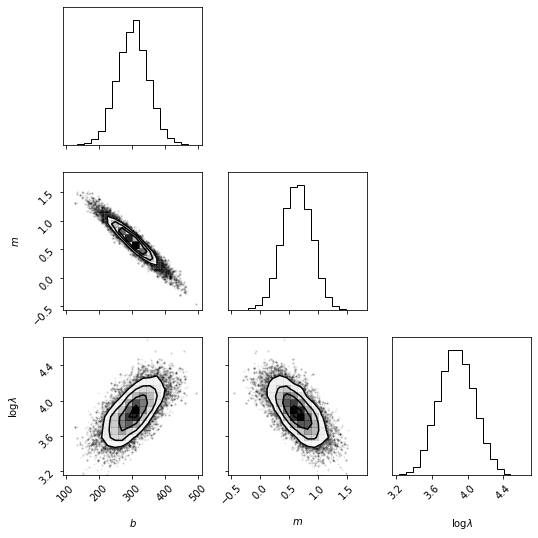

In [7]:
# mcmc sampling
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim,
    ln_probability,
    args=args
)

# burn in
pos, *_ = sampler.run_mcmc(p0, 500)
sampler.reset()

# sample
sampler.run_mcmc(pos, 1000)

# make corner plot
chain = sampler.chain.reshape((-1, ndim))
corner_fig = corner(
    chain,
    labels=(r"$b$", r"$m$", r"$\log{\lambda}$")
)
corner_fig.tight_layout()

Plot posterior predictions:

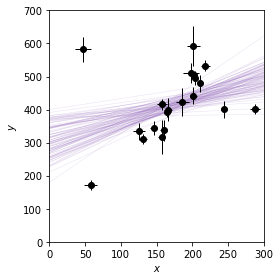

In [8]:
# make posterior predictions
predict_fig, ax = plt.subplots(figsize=(4, 4))
    
ax.scatter(x, y, c="k", s=10)
ax.errorbar(x, y,
            xerr=x_err, yerr=y_err, 
            fmt="o", lw=1, c="k")

xlim = np.array([0, 300])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
# plot draws of the posterior
for index in np.random.choice(chain.shape[0], size=100):
    b, m, ln_lambda = chain[index]
    ax.plot(
        xlim,
        m * xlim + b,
        "-",
        c="tab:purple",
        alpha=0.2,
        lw=0.5,
        zorder=-1
    )

ax.set_xlim(*xlim)
ax.set_ylim(0, 700)

predict_fig.tight_layout()


## Question 6

We will now do the same as Question 5, but with twice the error:

In [9]:
y_err2, x_err2 = 2*y_err, 2*x_err

Our covariance matrix becomes:

In [10]:
covs = np.array([[[x_e**2, 0],
                  [0, y_e**2]] for y_e, x_e in zip(y_err2, x_err2)])


And once again, we get initial conditions given by the linear algebra solution:

In [11]:
# get linalg solution
Y = np.atleast_2d(y).T

A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err2 * y_err2)

C_inv = np.linalg.inv(C)
G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)

# use ln_lambda = -3 and linalg solution for initialisation
args = (x, y, covs)
initial_theta = np.hstack([X.T[0], -3])

Now optimise and run emcee as before:

In [12]:
# optimisation
result = op.minimize(lambda *args: -ln_probability(*args), # want to minimise the -ve log probability
                     initial_theta,
                     args=args,
                     method="L-BFGS-B",
                     bounds=[(None, None), (None, None), (-10, 10)])
# mcmc sampling
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim,
    ln_probability,
    args=args
)

# burn in
pos, *_ = sampler.run_mcmc(p0, 500)
sampler.reset()

# sample
sampler.run_mcmc(pos, 1000)



State([[ 1.90358746e+02  1.18289233e+00  3.23290532e+00]
 [ 1.87195752e+02  1.31658968e+00 -6.83659656e+00]
 [ 2.14599156e+02  1.04179630e+00 -1.70909786e+00]
 [ 1.81966924e+02  1.17889602e+00 -3.79325516e+00]
 [ 2.23945570e+02  1.04620958e+00  3.35913477e+00]
 [ 2.06538328e+02  1.17790507e+00  5.59486133e-01]
 [ 2.46530338e+02  9.77350412e-01  2.94042355e+00]
 [ 2.10210348e+02  1.07984903e+00  2.54468908e+00]
 [ 2.42780049e+02  9.21103503e-01  3.30974189e+00]
 [ 2.67134964e+02  9.21868095e-01  3.61706682e+00]
 [ 1.32113386e+02  1.44843895e+00 -2.97470436e+00]
 [ 2.63235230e+02  8.30406059e-01  3.15723084e+00]
 [ 2.61850285e+02  8.85400475e-01  3.49237018e+00]
 [ 2.38193261e+02  9.53192266e-01  3.19108774e+00]
 [ 2.68027216e+02  8.71802346e-01  3.29122520e+00]
 [ 2.50161845e+02  9.22875433e-01  2.29685909e+00]
 [ 1.79372955e+02  1.27166692e+00  2.26281048e+00]
 [ 2.15225910e+02  1.10217107e+00  2.53273421e+00]
 [ 2.64334114e+02  8.64027925e-01  3.20641972e+00]
 [ 3.55534569e+02  3.5075

Sample Posterior from emcee:

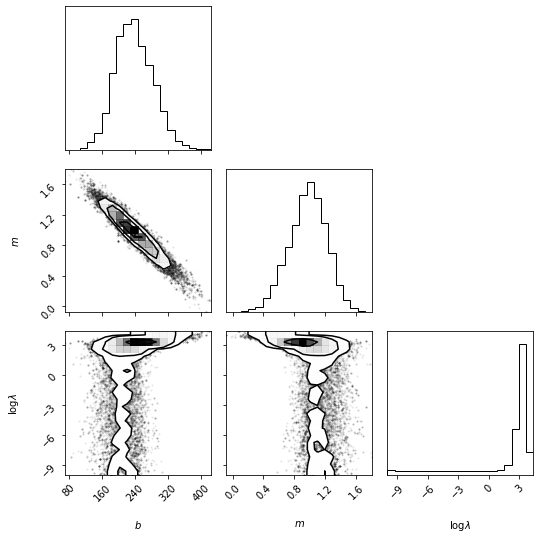

In [13]:
# make corner plot
chain = sampler.chain.reshape((-1, ndim))
corner_fig2 = corner(
    chain,
    labels=(r"$b$", r"$m$", r"$\log{\lambda}$")
)
corner_fig2.tight_layout()

Let's compare to initial posterior:

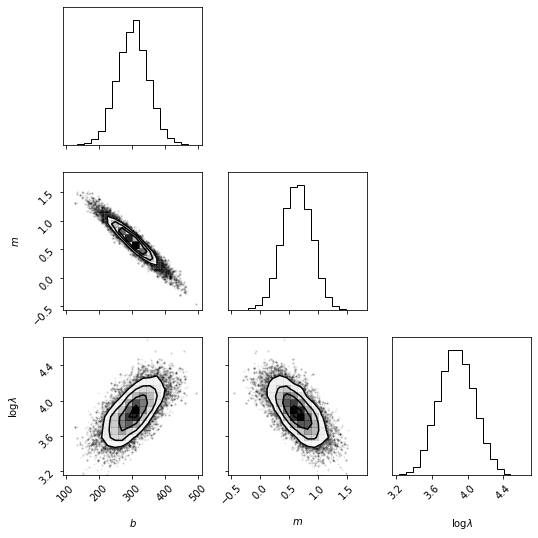

In [14]:
corner_fig

Now Plot posterior predictions:

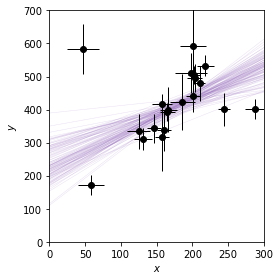

In [15]:
# make posterior predictions
predict_fig2, ax2 = plt.subplots(figsize=(4, 4))
    
ax2.scatter(x, y, c="k", s=10)
ax2.errorbar(x, y,
            xerr=x_err2, yerr=y_err2, 
            fmt="o", lw=1, c="k")

xlim = np.array([0, 300])
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")
    
ax2.xaxis.set_major_locator(MaxNLocator(6))
ax2.yaxis.set_major_locator(MaxNLocator(7))
    
# plot draws of the posterior
for index in np.random.choice(chain.shape[0], size=100):
    b, m, ln_lambda = chain[index]
    ax2.plot(
        xlim,
        m * xlim + b,
        "-",
        c="tab:purple",
        alpha=0.2,
        lw=0.5,
        zorder=-1
    )

ax2.set_xlim(*xlim)
ax2.set_ylim(0, 700)

predict_fig2.tight_layout()


Again, compare to the intial case:

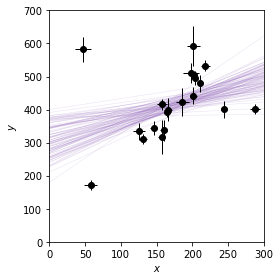

In [16]:
predict_fig

From the corner plots, we can see that the best $m$ and $b$ parameters remain largely unaffected. This seems reasonable because even though we have larger errors in the datapoints, every data point is affected in the same way, and so this should not have a huge effect on $m$ and $b$. The range of plausible values has increased however, as the larger errors allow for more options for $m$ and $b$ that give a reasonable solution. Doubling the errors gives support to models with a higher intrinsic scatter, as the increasing error essentially gives us a larger 'width' of the data.

## Question 7

We assume that the data is drawn from two distributions, a 'foreground' model, where the $y$ values are generated by a straight line and a 'background' model, where the data is drawn from a Gaussian with some large variance.
For the foreground model, we assume that:
1. there is some intrinsic scatter to the line,
2. there are uncertainties in the $x$ and $y$ direction, and
3. there is a correlation between the $x$ and $y$ uncertainties.

We introduce a parameter $q_i$ which indicates which model the data is drawn from, where $q_i = 0$ indicates the data is drawn from the straight line model, and $q_i = 1$ indicates the data is drawn from the outlier model.

We then get the expected frequency of the foreground model given by:

$$
        p(y_i,x_i|m,b,\lambda,\hat{x}_i,\mathbf{C}_i,\mathbf{\Lambda}, q_i = 0) = \frac{1}{\sqrt{2\pi\det{\left(\mathbf{C}_i + \mathbf{\Lambda}\right)}}}\exp\left(-\frac{1}{2}{\mathbf{R}_i}\transpose\left(\mathbf{C}_i + \mathbf{\Lambda}\right)^{-1}\mathbf{R}_i\right) \quad .
    $$

Where $\Lambda$ and $R_i$ are defined as they where in Question 4, and

$$
        \mathbf{C}_i \,=\, \left[\begin{array}{cc}
        \sigma_{xi}^2 & \rho_{xy,i}\sigma_{xi}\sigma_{yi} \\
        \rho_{xy,i}\sigma_{xi}\sigma_{yi} & \sigma_{yi}^2
        \end{array}
        \right] \quad .
    $$

The expected frequency of the background model is:

$$p(y_i|x_i,\sigma_{yi},\mu_{o},V_{o},q_i = 1) = \frac{1}{\sqrt{2\pi\left[\sigma_{yi}^2 + V_o\right]}}\exp\left(-\frac{\left[y_i - \mu_o\right]^2}{2\left[\sigma_{yi}^2 + V_{o}\right]}\right)$$

Where the parameters $\mu_0$ and $V_0$ represent the mean and variance of the outlier model

We assume the following priors on our parameters:

$$p(q_i) = \begin{cases}
      Q & \textrm{if } q_i = 0 \\
      1 - Q & \textrm{if } q_i = 1
      \end{cases}$$

Where, $Q$ is a new parameter representing membership probability, with prior:

$$
        p(Q) \sim \mathcal{U}\left(0, 1\right) \quad .
 $$  

Continuing on, we get priors:

$$
        p(\mu_0) \sim \mathcal{U}\left(0, 700\right) \quad , \\
        p(\log{V_0}) \sim \mathcal{U}\left(-5, 5\right) \quad , \\
        p(\ln\lambda) \sim \mathcal{U}\left(-10, 10\right) \quad , \\
                p(m,b) \sim (1 + m^2)^{-3/2}
 $$  

Marginalising over both $q$ and $\hat{x}$, we get the likelihood:

$$p(\vec{y},\vec{x} |\mathbf{\sigma_{y}},\vec{\theta}) = \prod_{i=1}^{N}\left[\frac{Q}{\sqrt{2\pi{\Sigma_i}^2}}\exp\left(-\frac{{\Delta_i}^2}{2{\Sigma_i}^2}\right) + \frac{1-Q}{\sqrt{2\pi\left[\sigma_{yi}^2 + V_o\right]}}\exp\left(-\frac{\left[y_i - \mu_o\right]^2}{2\left[\sigma_{yi}^2 + V_o\right]}\right)\right]$$

The log-likelihood is then given by:

$$
\log{\mathcal{L}} =  \sum_{i=1}^{N}\log{\left[\frac{Q}{\sqrt{2\pi{\Sigma_i}^2}}\exp\left(-\frac{{\Delta_i}^2}{2{\Sigma_i}^2}\right) + \frac{1-Q}{\sqrt{2\pi\left[\sigma_{yi}^2 + V_o\right]}}\exp\left(-\frac{\left[y_i - \mu_o\right]^2}{2\left[\sigma_{yi}^2 + V_o\right]}\right)\right]}$$

Combining the priors and taking the log, we get the log prior probability:

$$
\log{P(\mathbf{y}| \mathbf{\theta}, \mathbf{M})} = 
\left\{
        \begin{array}{ll}
            -\frac{3}{2} \log{(1 + m^2)} & \quad |\log{\lambda}| \leq 10 \text{ and } 0 \leq Q \leq 1 \text{ and } 0 \leq \mu_0 \leq 700 \text{ and } |\log{V_0}| \leq 5 \\
            -\infty & \quad \text{otherwise.}
        \end{array}
    \right.
    $$

Where $\mathbf{M}$ is our specified model.

Finally, we get our log posterior:

$$
\log{P(\mathbf{\theta}|\mathbf{y},\mathbf{M})}= 
\left\{
        \begin{array}{ll}
            -\frac{3}{2} \log{(1 + m^2)} +  \sum_{i=1}^{N}\log{\left[\frac{Q}{\sqrt{2\pi{\Sigma_i}^2}}\exp\left(-\frac{{\Delta_i}^2}{2{\Sigma_i}^2}\right) + \frac{1-Q}{\sqrt{2\pi\left[\sigma_{yi}^2 + V_o\right]}}\exp\left(-\frac{\left[y_i - \mu_o\right]^2}{2\left[\sigma_{yi}^2 + V_o\right]}\right)\right]}& \\ 
            \quad \dots \text{ for } |\log{\lambda}| \leq 10 \text{ and } 0 \leq Q \leq 1 \text{ and } 0 \leq \mu_0 \leq 700 \text{ and } |\log{V_0}| \leq 5 \\
            -\infty & \quad \text{otherwise.}
        \end{array}
    \right.
$$

## Question 8

In [17]:
# ranges of each parameter
r_b = np.arange(0, 500, 50)
n_b = len(r_b)
# this should instead be uniformly distributed in theta :/
r_m = np.arange(-10, 10, 2)
n_m = len(r_m)
r_Q = np.arange(0, 1, .1)
n_Q = len(r_Q)
r_mu = np.arange(0, 700, 70)
n_mu = len(r_mu)
r_ln_sigma_v = np.arange(-5, 5, 1)
n_v = len(r_ln_sigma_v)
r_ln_lambda = np.arange(-10, 10, 2)
n_lambda = len(r_ln_lambda)

In [18]:
grid = np.zeros((n_b, n_m, n_Q, n_mu, n_v, n_lambda))

In [19]:
def ln_prior(theta):
    b, m, Q, mu_o, ln_sigma_v, ln_lambda = theta
    if not (1 > Q > 0) \
    or not (700 > mu_o > 0) \
    or not (5 > ln_sigma_v > -5) \
    or not (10 > ln_lambda > -10):
        return -np.inf
    return -3/2 * np.log(1 + m**2)


def ln_likelihood_fg(theta, x, y, C):
    b, m, Q, mu_o, ln_sigma_v, ln_lambda = theta
    
    V = np.array([[-m, 1]]).T

    intrinsic_variance = np.exp(ln_lambda)**2
    Lambda = (intrinsic_variance / (1 + m**2)) * np.array([
        [m**2, -m],
        [-m,    1]
    ])

    Delta = (y - m * x - b)
    Sigma = (V.T @ (C + Lambda) @ V).flatten()

    return np.sum( - 0.5 * np.log(2 * np.pi)-np.log(Sigma) - 0.5 * Delta**2 / Sigma)

def ln_likelihood_bg(theta, x, y, y_err):
    b, m, Q, mu_o, ln_sigma_v, ln_lambda = theta
    total_variance = y_err**2 + np.exp(ln_sigma_v)**2
    return -0.5 * ((y - mu_o)**2 / total_variance) - 0.5 * np.log(total_variance)


def ln_probability(theta, x, y, y_err, C):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    b, m, Q, mu_o, ln_sigma_v, ln_lambda = theta

    ll_fg = np.log(Q) + ln_likelihood_fg(theta, x, y, C)
    
    ll_bg = np.log(1 - Q) + ln_likelihood_bg(theta, x, y, y_err)

    ll = np.sum(np.logaddexp(ll_fg, ll_bg))

    return lp + ll

In [20]:
covs = np.array([[[x_e**2, x_e*y_e*rho],
                  [x_e*y_e*rho, y_e**2]] for y_e, x_e, rho in zip(y_err, x_err, rho_xy)])

for i_b in range(n_b):
    b = r_b[i_b]
    for i_m in range(n_m):
        m = r_m[i_m]
        for i_Q in range(n_Q):
            Q = r_Q[i_Q]
            for i_mu in range(n_mu):
                mu_o = r_mu[i_mu]
                for i_v in range(n_v):
                    ln_sigma_v = r_ln_sigma_v[i_v]
                    for i_l in range(n_lambda):
                        ln_lambda = r_ln_lambda[i_l]
                        
                        theta = (b, m, Q, mu_o, ln_sigma_v, ln_lambda)
                        grid[i_b, i_m, i_Q, i_mu, i_v, i_l] = ln_probability(theta, x, y, y_err, covs)

So it looked like it worked, but I ran out of time to plot it :/